In [1]:
import sys
sys.path.append("/home/tromero_client/RL-LRP")
from experiments import WrapperNet
from torchvision.models import VGG
import torch


In [2]:
import torch
from torchvision import models, transforms
import torchvision.datasets as datasets
from PIL import Image

def load_image(image_path):
    # Define transformations for the image
    transformation = transforms.Compose([
        transforms.Resize((224, 224)),  # VGG16 uses 224x224 images
        transforms.ToTensor(),  # Transform it into a torch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
    ])

    # Load the image
    image = Image.open(image_path)
    image = transformation(image).unsqueeze(0)  # Add batch dimension
    return image

def get_model():
    # Load a pretrained VGG-16 model
    model = models.vgg16(pretrained=True)
    model.eval()  # Set the model to inference mode
    return model

def predict(image, model):
    with torch.no_grad():  # Inference doesn't require gradient computation
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted


# Load the model
model = get_model()

# Load an image (specify the path to your image)
image_path = 'Lion.jpg'
image = load_image(image_path)

# Get prediction
prediction = predict(image, model)
print("Predicted class:", prediction.item())


/home/tromero_client/miniconda3/envs/rl_lrp_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tromero_client/miniconda3/envs/rl_lrp_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: 291


In [3]:
import sys
sys.path.append("../")
from experiments import WrapperNet
wrapped_model = WrapperNet(model.eval(), hybrid_loss=True)

In [4]:
model


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
out, class_ = wrapped_model(image)
class_.shape

index: 0 	layer: ('Linear', Linear(in_features=4096, out_features=1000, bias=True))
total relevance:  21.680828094482422
relevance mean value: 0.0052931709215044975
index: 1 	layer: ReLU
total relevance:  21.680828094482422
relevance mean value: 0.0052931709215044975
index: 2 	layer: ('Linear', Linear(in_features=4096, out_features=4096, bias=True))
total relevance:  20.88039779663086
relevance mean value: 0.005097753368318081
index: 3 	layer: ReLU
total relevance:  20.88039779663086
relevance mean value: 0.005097753368318081
index: 4 	layer: ('Linear', Linear(in_features=25088, out_features=4096, bias=True))
total relevance:  20.596025466918945
relevance mean value: 0.0008209512452594936
index: 5 	layer: AdaptiveAvgPool2d
total relevance:  20.596025466918945
relevance mean value: 0.0008209512452594936
index: 6 	layer: MaxPool2d
total relevance:  20.596027374267578
relevance mean value: 0.00020523784041870385
index: 7 	layer: ReLU
total relevance:  20.596027374267578
relevance mean val

torch.Size([1, 3, 224, 224])

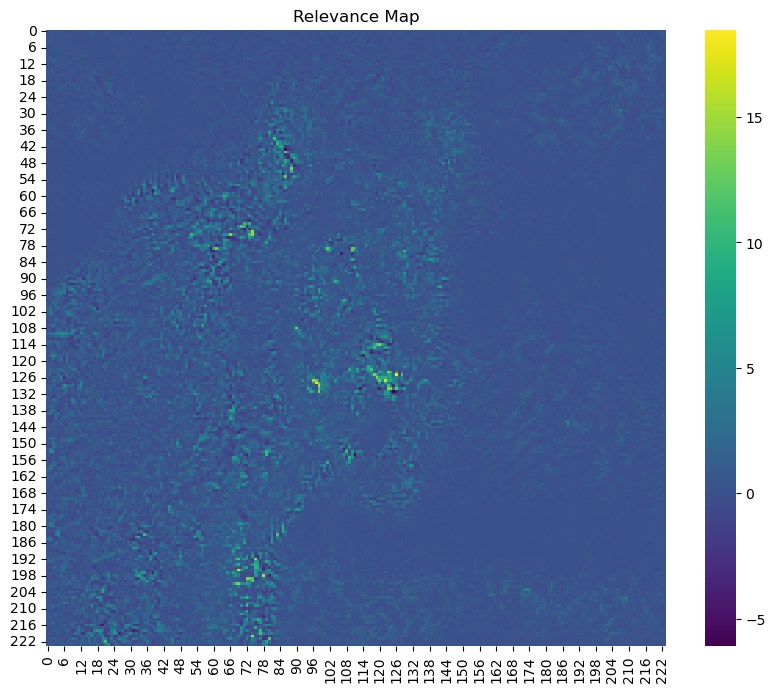

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch  # Assuming your data is in PyTorch tensors
output_tensor = class_.max(dim=1)[0][0]
# output_tensor.shape
output_final =output_tensor.cpu().detach().numpy()
output_final[0].shape
plt.figure(figsize=(10, 8))  # Set the size of the figure (optional)
sns.heatmap(output_final, cmap='viridis', annot=False)
plt.title('Relevance Map')
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
import torch



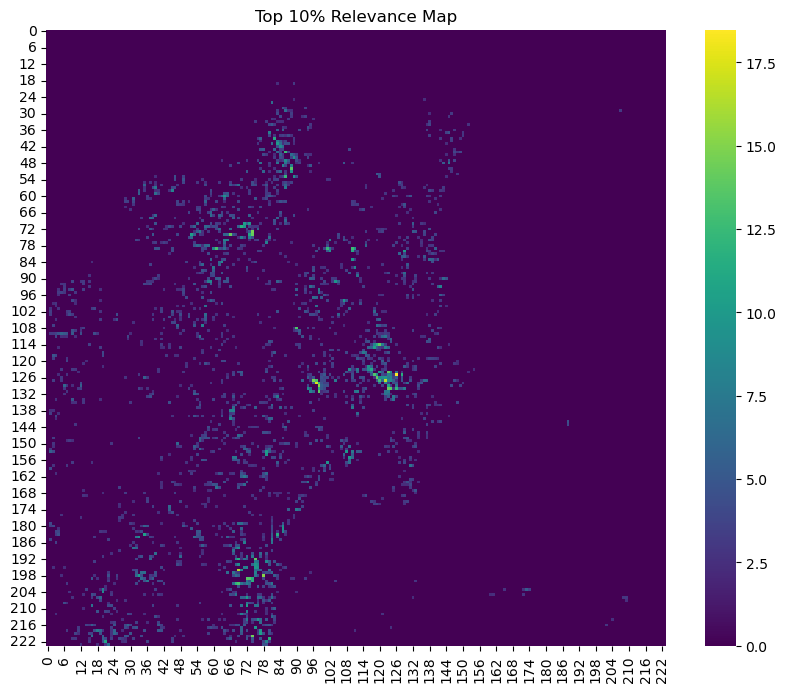

In [12]:
def plot_top_10_percent_heatmap(class_):
    output_tensor = class_.max(dim=1)[0][0]
    # Get the top 10% threshold
    top_10_percent_threshold = torch.quantile(output_tensor, 0.95)

    # Mask out values below the top 10% threshold
    mask = output_tensor >= top_10_percent_threshold

    # Apply the mask to the output tensor
    filtered_output = torch.zeros_like(output_tensor)
    filtered_output[mask] = output_tensor[mask]

    # Convert to numpy for plotting
    output_final = filtered_output.cpu().detach().numpy()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))  # Set the size of the figure (optional)
    sns.heatmap(output_final, cmap='viridis', annot=False)
    plt.title('Top 10% Relevance Map')
    plt.show()

# Assuming your data is in PyTorch tensors and has the shape b, 2, 224, 224

plot_top_10_percent_heatmap(output_tensor.cpu().detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


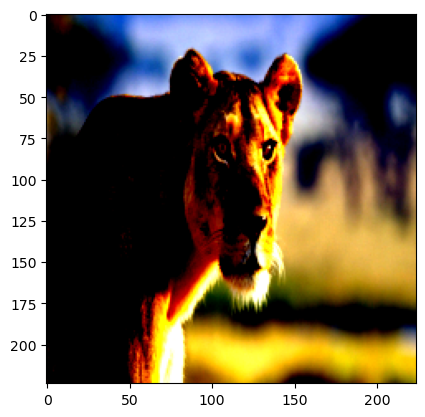

In [7]:
plt.imshow(image.squeeze(0).permute(1, 2, 0))

In [ ]:
# for batch of inputs, calculate heatmaps, and select top 10% of pixels in each heatmap. 
# Store in dataset format as a dataset to be trained on. 
# We need a teacher model for VGG

